In [276]:
import gym
#import random
import numpy as np
import matplotlib.pyplot as plt

#import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

#from tflearn.layers.core import input_data, dropout, fully_connected
#from tflearn.layers.estimator import regression
from statistics import median, mean
from collections import Counter

env = gym.make("CartPole-v0")
env.reset()
goal_steps = 500
score_requirement = 60
initial_games = 10000

# Execute Episodes - Generate Examples

In [277]:
def GenerateExamples(model = None):
    # [OBS, MOVES, SCORE]
    examples = []
    accepted_scores = []    # just the scores that met our threshold
    
    # --------------- ITERATE THROUGH 10000 EPISODE ------------------
    for _ in range(initial_games):
        # reset env to play again
        env.reset()
        score = 0
        game_memory = []    # actions taken
        prev_observation = []
        
        # --------- ITERATE UP TO 500 STEPS PER EPISODE -------------
        for _ in range(goal_steps):
            
            action = random.randrange(0, 2)   # choose random action (0-left or 1-right)
            observation, reward, done, info = env.step(action)
            
            # --------- STORE STATE-ACTION PAIR + SCORE-(need to convert this to E[return]) ------------
            # this is the previous ovservation and the action taken from it
            if len(prev_observation) > 0 :
                game_memory.append([prev_observation, action, score])
                
            prev_observation = observation
            score += reward    # +1 for every frame we haven't fallen
            if done: 
                break

        # --------- SAVE EXAMPLE (EPISODE) IF (SCORE > THRESHOLD) ----------
        # This saves state action pairs in a np.array(np[4x1 state array], np[1x1 action])
        # Note, it does not save the score! Therefore all episodes with score > threshold
        # are treated equally (not the best way of doing this!)
        if score >= score_requirement:
            accepted_scores.append(score)
            for data in game_memory:
                
                #if data[1] == 1:
                #    output = np.array([0,1])
                #elif data[1] == 0:
                #    output = np.array([1,0])
                #examples.append([data[0], output])
                
                #don't seem to need one hot for pytorch?
                #use examples.append(data) if don't need returns
                examples.append(   np.append(data[0:2], score - data[2])   )
    
    # just in case you wanted to reference later
    #training_data_save = np.array(examples)
    #np.save('saved.npy',training_data_save)
    
    # some stats here, to further illustrate the neural network magic!
    print('Average accepted score:',mean(accepted_scores))
    print('Median score for accepted scores:',median(accepted_scores))
    print(Counter(accepted_scores))
    
    
    #Examples are of the form:
    #[array([array([-0.02307806,  0.15235257, -0.01190175, -0.32549727]), 0, 59.0], dtype=object), 
    # array([array([-0.020031  , -0.04259792, -0.0184117 , -0.03659128]), 0, 58.0], dtype=object), 
    # array([array([-0.02088296, -0.23745107, -0.01914353,  0.25022618]), 0, 57.0], dtype=object), 
    
    return examples



In [278]:
GenerateExamples()

Average accepted score: 71.2987012987013
Median score for accepted scores: 67.0
Counter({63.0: 16, 61.0: 15, 62.0: 12, 60.0: 11, 64.0: 8, 67.0: 8, 65.0: 6, 74.0: 6, 68.0: 5, 70.0: 5, 76.0: 4, 71.0: 4, 66.0: 4, 87.0: 4, 69.0: 4, 80.0: 4, 86.0: 3, 72.0: 3, 75.0: 3, 82.0: 3, 89.0: 3, 94.0: 2, 85.0: 2, 79.0: 2, 78.0: 2, 90.0: 2, 84.0: 2, 73.0: 2, 107.0: 1, 103.0: 1, 100.0: 1, 98.0: 1, 114.0: 1, 95.0: 1, 109.0: 1, 104.0: 1, 77.0: 1})


[array([array([ 0.03461118, -0.1921883 ,  0.04374701,  0.31262874]), 1,
        106.0], dtype=object),
 array([array([0.03076742, 0.00228401, 0.04999958, 0.03405689]), 1, 105.0],
       dtype=object),
 array([array([ 0.0308131 ,  0.19665462,  0.05068072, -0.24244091]), 1,
        104.0], dtype=object),
 array([array([ 0.03474619,  0.39101739,  0.0458319 , -0.51871697]), 0,
        103.0], dtype=object),
 array([array([ 0.04256654,  0.19528115,  0.03545756, -0.21195106]), 0,
        102.0], dtype=object),
 array([array([ 0.04647216, -0.00032934,  0.03121854,  0.0917026 ]), 0,
        101.0], dtype=object),
 array([array([ 0.04646557, -0.19588453,  0.0330526 ,  0.3940692 ]), 0,
        100.0], dtype=object),
 array([array([ 0.04254788, -0.39145952,  0.04093398,  0.69698716]), 1,
        99.0], dtype=object),
 array([array([ 0.03471869, -0.19692841,  0.05487372,  0.41746615]), 0,
        98.0], dtype=object),
 array([array([ 0.03078012, -0.39278332,  0.06322305,  0.7269311 ]), 1,
        

# Create Model

In [271]:
# Training settings
batch_size = 64

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.l1 = nn.Linear(4, 128)
        self.l2 = nn.Linear(128, 256)
        self.l3 = nn.Linear(256, 128)
        self.l4 = nn.Linear(128, 32)
        
        self.dp = nn.Dropout(p = 0.3)  # Suragnair used 0.3
        self.fc1 = nn.Linear(32, 2)    # want an action vector output: [log(prob right), log(prob left)]
        self.fc2 = nn.Linear(32, 1)    # Output the expected return

    def forward(self, obs):
        #in_size = x.size(0)
        x = F.relu(self.dp(self.l1(obs)))
        x = F.relu(self.dp(self.l2(x)))
        x = F.relu(self.dp(self.l3(x)))
        x = F.relu(self.dp(self.l4(x)))
        
        #x = x.view(in_size, -1)  # flatten the tensor
        a = self.fc1(self.dp(x))
        action_probs = F.log_softmax(a, dim = -1)    # choose the dimension such that we get something like 
                                          # [exp(-0.6723) +  exp(-0.7144)] = 1 for the output
        v = self.fc2(self.dp(x))  # get a linear value for the expected return
        return action_probs, v                      
    


model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Train Model

In [297]:
def train_model(epoch, examples):
    model.train()
    action_loss, value_loss, accuracy = [], [], []
    
    # ------------- CONVERT TO CORRECT DATA TYPE ----------------
    gpu = torch.device("cpu")
    allStates= torch.tensor(  np.array([i[0] for i in examples]),  dtype = torch.float, device = gpu)       #reshapes into a (23002, 4) array
    allActions = torch.tensor(  np.array([i[1] for i in examples]), dtype = torch.long, device = gpu)    #reshapes into a (23002, 2) array 
    allReturns = torch.tensor(  np.array([i[2] for i in examples]),  dtype = torch.float, device = gpu) 
    
    # We should permute data before batching really. (X is a torch Variable)
    #permutation = torch.randperm(X.size()[0])

    
    for index in range(0, allStates.size()[0], batch_size):        

        # -------- GET BATCHES -----------
        #indices = permutation[i:i+batch_size]
        batch_idx = int(index / batch_size) + 1 #add one so stats print properly
        batch_states = allStates[index : index+batch_size] # torch.Size([64, 4])
        batch_actions = allActions[index : index+batch_size] # torch.Size([64])
        batch_returns = allReturns[index: index+batch_size] # torch.Size([64])

        # --------- TRAIN & BACKPROP ----------
        optimizer.zero_grad()
        pred_actions, state_value = model(batch_states) # torch.Size([64, 2]) and torch.Size([64, 1])
        
        a_loss = F.nll_loss(pred_actions, batch_actions)
        # Suragnair uses tanh for state_values, but their values are E[win] = [-1, 1] where -1 = loss
        # Here we are using the length of time that we have been "up"
        v_loss = F.binary_cross_entropy(torch.sigmoid(state_value[:, 0]), torch.sigmoid(batch_returns))
        
        action_loss.append(a_loss)
        value_loss.append(v_loss)
        tot_loss = a_loss*100 + v_loss # pareto optimality?
        
        # Should try and get this to work with one hot!
        tot_loss.backward()
        optimizer.step()
                
        # --------- PRINT STATS --------------
        # Get array of predicted actions and compare with target actions to compute accuracy
        arg = torch.argmax(pred_actions, dim = 1)
        accuracy.append(  1 - (torch.abs(arg - batch_actions).sum().detach().numpy()) / batch_size    ) #counts the different ones
        
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tAccuracy: {:.5f}'.format(
                epoch, 
                batch_idx * batch_size, 
                allStates.size()[0],
                100 * batch_idx * batch_size / allStates.size()[0], 
                tot_loss,
                accuracy[batch_idx - 1])
                  
             )

    return action_loss, value_loss, accuracy

In [298]:
training_data = GenerateExamples()

Average accepted score: 71.7483870967742
Median score for accepted scores: 68.0
Counter({61.0: 12, 63.0: 11, 67.0: 11, 60.0: 10, 70.0: 9, 65.0: 9, 72.0: 8, 64.0: 8, 68.0: 7, 62.0: 7, 75.0: 6, 86.0: 5, 69.0: 4, 66.0: 4, 80.0: 4, 74.0: 4, 89.0: 3, 78.0: 3, 90.0: 3, 76.0: 3, 71.0: 3, 83.0: 2, 97.0: 2, 101.0: 2, 81.0: 2, 84.0: 2, 79.0: 2, 91.0: 1, 77.0: 1, 88.0: 1, 99.0: 1, 115.0: 1, 93.0: 1, 130.0: 1, 73.0: 1, 82.0: 1})


In [299]:
a_loss, v_loss, batch_acc = train_model(1, training_data)

Train Epoch: 1 [64/10966 (1%)]	Loss: 65.623703 	Accuracy: 0.59375
Train Epoch: 1 [128/10966 (1%)]	Loss: 68.553093 	Accuracy: 0.56250
Train Epoch: 1 [192/10966 (2%)]	Loss: 62.858494 	Accuracy: 0.64062
Train Epoch: 1 [256/10966 (2%)]	Loss: 73.614792 	Accuracy: 0.51562
Train Epoch: 1 [320/10966 (3%)]	Loss: 61.122032 	Accuracy: 0.73438
Train Epoch: 1 [384/10966 (4%)]	Loss: 80.439865 	Accuracy: 0.57812
Train Epoch: 1 [448/10966 (4%)]	Loss: 66.777283 	Accuracy: 0.56250
Train Epoch: 1 [512/10966 (5%)]	Loss: 67.967819 	Accuracy: 0.54688
Train Epoch: 1 [576/10966 (5%)]	Loss: 67.545250 	Accuracy: 0.59375
Train Epoch: 1 [640/10966 (6%)]	Loss: 63.478710 	Accuracy: 0.65625
Train Epoch: 1 [704/10966 (6%)]	Loss: 64.745483 	Accuracy: 0.59375
Train Epoch: 1 [768/10966 (7%)]	Loss: 75.326683 	Accuracy: 0.51562
Train Epoch: 1 [832/10966 (8%)]	Loss: 70.437325 	Accuracy: 0.60938
Train Epoch: 1 [896/10966 (8%)]	Loss: 67.356949 	Accuracy: 0.59375
Train Epoch: 1 [960/10966 (9%)]	Loss: 68.274529 	Accuracy: 0.53

Train Epoch: 1 [8064/10966 (74%)]	Loss: 65.221901 	Accuracy: 0.68750
Train Epoch: 1 [8128/10966 (74%)]	Loss: 64.890556 	Accuracy: 0.54688
Train Epoch: 1 [8192/10966 (75%)]	Loss: 74.247429 	Accuracy: 0.54688
Train Epoch: 1 [8256/10966 (75%)]	Loss: 68.545441 	Accuracy: 0.54688
Train Epoch: 1 [8320/10966 (76%)]	Loss: 65.609818 	Accuracy: 0.67188
Train Epoch: 1 [8384/10966 (76%)]	Loss: 62.879215 	Accuracy: 0.60938
Train Epoch: 1 [8448/10966 (77%)]	Loss: 63.637333 	Accuracy: 0.60938
Train Epoch: 1 [8512/10966 (78%)]	Loss: 68.251335 	Accuracy: 0.54688
Train Epoch: 1 [8576/10966 (78%)]	Loss: 78.741135 	Accuracy: 0.67188
Train Epoch: 1 [8640/10966 (79%)]	Loss: 66.573204 	Accuracy: 0.60938
Train Epoch: 1 [8704/10966 (79%)]	Loss: 71.397125 	Accuracy: 0.59375
Train Epoch: 1 [8768/10966 (80%)]	Loss: 66.865715 	Accuracy: 0.59375
Train Epoch: 1 [8832/10966 (81%)]	Loss: 64.896889 	Accuracy: 0.59375
Train Epoch: 1 [8896/10966 (81%)]	Loss: 71.702614 	Accuracy: 0.45312
Train Epoch: 1 [8960/10966 (82%)]	

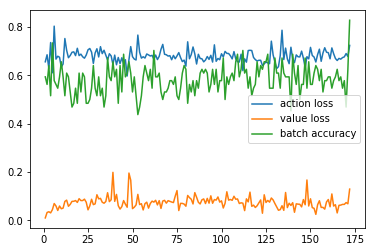

In [300]:
x = np.linspace(1, len(a_loss), num = len(a_loss))
plt.plot(x, a_loss)
plt.plot(x, v_loss)
plt.plot(x, batch_acc)
plt.legend(["action loss", "value loss", "batch accuracy"])
plt.show()

# Test the Model 

In [293]:
print(torch.tensor(training_data[-1][0], dtype = torch.float)) # print some observation
# and predict some action from that observation
action_prob, e_value = model.forward(torch.tensor(training_data[-1][0], dtype = torch.float))
action = np.argmax(    action_prob.detach().numpy()    )
print(action)

tensor([ 0.5893,  1.7644, -0.1807, -1.9867])
0


In [302]:
def test():
    
    model.eval()
    scores, expected_scores, choices = [], np.zeros(goal_steps), []
    
    # ------- PLAY SOME TEST GAMES ----------
    for each_game in range(50):
        env.reset()
        score, E_score = 0, []
        game_memory, prev_obs = [], []
        
        for _ in range(goal_steps):    # play up to (500) frames
            #env.render()
            
            # ----- GENERATE AN ACTION -------
            if len(prev_obs)==0:    # start by taking a random action
                action = random.randrange(0,2)   
                
            else:                   # After that take the best predicted action by the neural net
                x = torch.tensor(   prev_obs,   dtype = torch.float    )
                action_prob, e_score = model.forward(x)
                action = np.argmax(   action_prob.detach().numpy()   )
                E_score.append(   np.array(e_score.detach())[0]   )  # see how the game updates it expected score as we move through

            new_observation, reward, done, info = env.step(action)
            prev_obs = new_observation
            
            # ----- RECORD RESULTS -------
            choices.append(action)   # just so we can work out the ratio of what we're predicting
            
            game_memory.append([new_observation, action])
            score += reward
            if done: break

        scores.append(score)    # Record the score of each game
        padding = np.zeros(int(goal_steps - score + 1), dtype = int)
        E_score = np.append([np.array(E_score)], [padding])
        expected_scores = np.vstack((expected_scores, E_score))

    print("Score Req: ", score_requirement)
    print('Average Score:',sum(scores)/len(scores))
    print('choice 1 (right): {:.4f}  choice 0 (left): {:.4f}'.format(choices.count(1)/len(choices),choices.count(0)/len(choices)))
    print(Counter(scores))
    
    return expected_scores

Score Req:  60
Average Score: 183.42
choice 1 (right): 0.5015  choice 0 (left): 0.4985
Counter({200.0: 33, 145.0: 3, 149.0: 1, 129.0: 1, 144.0: 1, 152.0: 1, 156.0: 1, 130.0: 1, 148.0: 1, 185.0: 1, 142.0: 1, 160.0: 1, 194.0: 1, 153.0: 1, 157.0: 1, 137.0: 1})


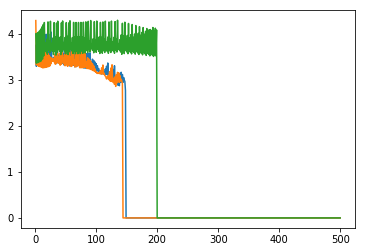

In [303]:
expected_scores = test()
x = np.linspace(1, len(expected_scores[0]), num = len(expected_scores[0]))
plt.plot(x, expected_scores[1])
plt.plot(x, expected_scores[6])
plt.plot(x, expected_scores[3])
plt.show()
